Pytorch에서는 `DataLoader`에서 반복문으로 데이터를 받아와 그 데이터를 모델에 넣어 사용합니다.

그 과정에서 우리는 데이터를 `Tensor`로 받아 사용하는데 여기서 우리는 `.contigious()`, `.cuda()` 등등 여러 메서드들을 많이 사용하고, 어떤 책에서는 `Variable`을 사용하기도 합니다.

`Tensor`와 `Variable`을 살펴봅시다.

# Tensor와 Variable

> **정확히는 `torch.Tensor`와 `torch.autograd.Variable`**

`Tensor`와 `Variable`은 2018년에 합쳐진 class로 이제는 `Tensor`로 통합되었습니다.

기존에는 Variable에서 gradient를 자동으로 계산해주는 역할을 해주었지만, 이제는 Tensor가 그 기능을 할 수 있게 되었습니다.

즉, Variable을 사용할 수는 있지만 Tensor로 리턴하니 굳이 사용할 필요는 없는 클래스입니다.

`requires_grad`로 gradient 계산 여부를 Tensor에서 사용할 수 있습니다.

# Tensor의 자료형

Tensor의 자료형은 CPU tensor이나 GPU tensor이냐에 따라 구분됩니다.

`torch.x`가 CPU tensor라면 `torch.cuda.x`가 GPU tensor가 됩니다. 다음은 표입니다.

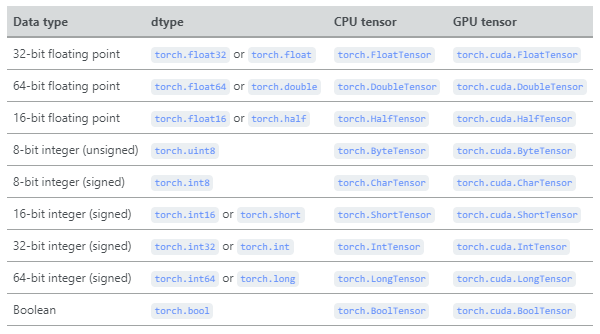

실수의 경우는 부호여부를 따지지 않고, floating point에 따라 half(16), float(32), double(64)로 나뉩니다. 메모리의 여유에 따라 데이터 자체의 유효숫자 범위를 줄이며 훈련할 때 형변환을 하는 경우가 많습니다. (double to float)

이후 정수형 데이터는 8bit unsigned를 제외하고 signed(부호있는)이며, 8, 16, 32, 64 비트로 구분됩니다.

실사용 예시를 본 적은 없으나 boolean도 있습니다.

**다른 설명이 없다면 default Tensor는 `torch.FloatTensor` 입니다.**

# torch.tensor

우선 `torch.tensor` 함수는 data를 `Tensor` 객체로 만들어주는 함수이며 각 parameter는 다음과 같습니다.

* `data` : list나 Numpy의 ndarray 등 array류의 데이터
* `dtype` : 데이터의 타입, 선언하지 않으면 보통 data에 맞춰서 적절하게 들어간다.
* `device` : default는 None이나 torch.set_default_tensor_type()에 맞게 들어간다.
* `requires_grad` : default는 False이며, gradient 값 저장 유무
* `pin_memory` : True시 pinned memory에 할당, CPU tensor에서 가능하다.

각 parameter를 보면 Tensor가 에러 나는 이유가 몇 가지 보입니다.

* data가 Tensor로 변환이 되는 data인가?
* 연산하고 있는 Tensor간 data type이 같은가?
* 연산시 CPU Tensor와 GPU Tensor를 같은 device로 통일했는가?

그럼 이런 문제를 해결하기 위해 사용하는, 알아두면 좋은 함수와 메서드를 살펴봅시다.

# torch.tensor 관련 함수와 메서드들

**자료형 및 기기 선언과 변경**

자료형은 선언시에는 다음과 같이 `dtype`을 사용하여 지정해줄 수 있습니다.

In [1]:
import torch

In [2]:
device = torch.device("cuda")
x = torch.tensor([[1, 2, 3], [4, 5, 6]], dtype=torch.int32, device=device)
print(x)
print(x.requires_grad)

tensor([[1, 2, 3],
        [4, 5, 6]], device='cuda:0', dtype=torch.int32)
False


여기서 tensor의 `dtype`이나 `device`를 바꾸는 방법은 `torch.as_tensor`를 사용하면 됩니다.

In [3]:
y = torch.as_tensor(x, dtype=torch.half, device='cpu')
print(y)
print(y.requires_grad)

tensor([[1., 2., 3.],
        [4., 5., 6.]], dtype=torch.float16)
False


또는 `.to()` method를 사용하는 방법도 있습니다.

In [4]:
y = x.to(device=device, dtype=torch.float64)
print(y)
print(y.requires_grad)

tensor([[1., 2., 3.],
        [4., 5., 6.]], device='cuda:0', dtype=torch.float64)
False


* 그 외에도 기기는 `.cpu()`, `.cuda()`로 기기를 변경할 수 있습니다.
* 자료형은 `.half()`, `.float()`, `.double()`로 변경할 수 있습니다.
* `torch.new_tensor`로 다른 정보를 유지하면서 새로운 Tensor를 만들 수도 있습니다.

In [5]:
z = y.new_tensor(y, requires_grad=True)
print(z)
print(y.requires_grad)
print(z.requires_grad)

tensor([[1., 2., 3.],
        [4., 5., 6.]], device='cuda:0', dtype=torch.float64,
       requires_grad=True)
False
True


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [6]:
recommended_z = y.clone().detach()
print(recommended_z)

tensor([[1., 2., 3.],
        [4., 5., 6.]], device='cuda:0', dtype=torch.float64)


**메서드 with underbar**

언더바(_) 하나 차이인 torch.FloatTensor.abs_()가 있으면 torch.FloatTensor.abs()가 있습니다.

* 언더바가 있다면 : in_place (새로운 tensor가 생기지 않고 기존 tensor 변경)
* 언더바가 없다면 : 새로운 tensor를 리턴

거의 대부분의 메소드는 언더바 버전이 있기때문에 참고하면 좋습니다.

**복사의 수많은 방법 : detach() & clone() & .data**

`detach()` 와 `clone()` 은 기존 Tensor를 복사하는 방법 중 하나입니다.

* `detach()` : 기존 Tensor에서 gradient 전파가 안되는 텐서 생성

> 단, storage를 공유하기에 detach로 생성한 Tensor가 변경되면 원본 Tensor도 똑같이 변합니다.

* `clone()` : 기존 Tensor와 내용을 복사한 텐서 생성

`with torch.no_grad()` 로 grad를 사용하지 않는 방법과 `detach()` 로 하는 방법은 무슨 차이가 있을까요?

사실 없습니다. 단 `torch.no_grad()` 는 범위 내의 `require_grad`를 모두 `False`로 만드므로 grad에 따라 적재적소에 사용하면 됩니다.

하지만 여기서 또 애매한 부분은 기존의 `.data`는 `.detach()`와 어떻게 다르냐 입니다. `.data`도 기본적인 내용은 `.detach()`와 다를게 없습니다.

원래 `.data`는 `Variable`에서 `Tensor`를 얻기 위해 사용하는 방법이었습니다. `Tensor`에서도 유사하게 데이터를 가져오면서 `required_grad=False`로 Tensor를 가져옵니다.

그러나 예시에 따르면 `.data`는 잘못된 gradient를 계산해도 이를 update에 사용하는 반면에 `detach()`는 잘못 계산된 gradient의 경우 에러가 발생합니다.

**=> 결론은 `.data`를 쓰지 마라.**

복사하는 함수로는 `torch.new_tensor(x)`를 쓸 수 있습니다.

그리고 메서드를 활용하여 같은 동작은 `x.clone().detach()`로 할 수 있습니다.

 `requires_grad=True`를 넣어준다면 `torch.new_tensor(x, requires_grad=True)`로 쓰고, `x.clone().detach().requires_grad_(True)`로도 쓸 수 있습니다.

**congiguous()의 용도**

`narrow()`, `view()`, `expand()`, `transpose()` 등의 함수는 새로운 Tensor를 생성하는 게 아니라 기존의 Tensor에서 메타데이터만 수정하여 우리에게 정보를 제공합니다. **즉 메모리상에서는 같은 공간을 공유합니다.**

하지만 연산 과정에서 Tensor가 메모리에 올려진 순서(메모리 상의 연속성)가 중요하다면 원하는 결과가 나오지 않을 수 있고 에러가 발생합니다. 그렇기에 어떤 함수 결과가 실제로 메모리에도 우리가 기대하는 순서로 유지하려면 `.contiguous()`를 사용하여 에러가 발생하는 것을 방지할 수 있습니다.

In [7]:
x = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])   # torch.narrow(input=좁힐 텐서, dim, start=시작 차원, length=끝 차원)
print(x)
print(torch.narrow(x, 0, 0, 2))   
print(torch.narrow(x, 1, 1, 2))

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])
tensor([[1, 2, 3],
        [4, 5, 6]])
tensor([[2, 3],
        [5, 6],
        [8, 9]])


In [8]:
x = torch.randn(4, 4)
y = x.view(16)
z = x.view(-1, 8)  # -1은 다른 차원에서 유추합니다.
print(x.size(), y.size(), z.size())

torch.Size([4, 4]) torch.Size([16]) torch.Size([2, 8])


In [16]:
x = torch.tensor([[1], [2], [3]])
print(x.size())
print(x)
print(x.expand(3,6))
print(x.expand(-1,6))

torch.Size([3, 1])
tensor([[1],
        [2],
        [3]])
tensor([[1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3]])
tensor([[1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3]])


In [36]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]]) # x is contiguous
print(x)
y = x.transpose(0, 1) # y is non-contiguous
print(y)

tensor([[1, 2, 3],
        [4, 5, 6]])
tensor([[1, 4],
        [2, 5],
        [3, 6]])


In [37]:
print(x.data_ptr())
print(y.data_ptr())

94424988842432
94424988842432


`x`는 `contiguous`하기 때문에 x[0][0]과 x[0][1]는 memory에서 이웃하지만 y[0][0]과 y[0][1]은 그렇지 않다.

In [38]:
print(x.is_contiguous()) # True
print(y.is_contiguous()) # False

True
False


**더미 차원 추가와 삭제 : squeeze() & unsqueeze()**

`Tensor`는 결국 모델에 넣기 위한 data의 변형이며 data에 따라 Tensor의 차원도 달라집니다. 보통 모델에 넣는 데이터의 shape은 다음과 같습니다.

*   signal data `N, C, L` : batch, channel, length
*   image data `N, C, H, W` : batch, channel, height, weight

하지만 inference시 batchsize가 1이 되어 shape이 안맞는 경우, 아니면 후에 Conv연산을 위해 가상 channel이 필요한 경우, tensor간 연산을 위해 channel을 추가해야하는 경우 등등 size가 1인 차원을 추가하거나 없애야하는 상황이 많습니다.

*   `squeeze()` : 차원의 size가 1인 차원을 없애줌
> 여러개의 차원 중 특정 차원만 지우고 싶다면 `x.squeeze(1)`처럼 사용, 아니면 모두 제거

*   `unsqueeze()` : 차원 size가 1인 차원을 생성
> idx번째 차원을 만들면 기존 idx차원부터 한칸씩 미뤄짐


In [31]:
x = torch.rand(1, 1, 20, 128)
print(x.size())
x = x.squeeze()
print(x.size())

x2 = torch.rand(1, 1, 20, 128)
print(x2.size())
x2 = x2.squeeze(dim=1)
print(x2.size())

torch.Size([1, 1, 20, 128])
torch.Size([20, 128])
torch.Size([1, 1, 20, 128])
torch.Size([1, 20, 128])


In [34]:
x = torch.rand(3, 20, 128)
print(x.size())
x = x.unsqueeze(dim=1)
print(x.size())

torch.Size([3, 20, 128])
torch.Size([3, 1, 20, 128])


**차원 재구성 (1) : reshape() & view()**

둘 모두 문법은 동일합니다. `x.view(1, 2, 3)`, `x.reshape(1, 2, 3)`처럼 변경하고 싶은 shape을 tuple로 입력으로 주면 됩니다.

여기서는 정말 미세한 차이가 있습니다.

*  ` view`는 기존의 데이터와 같은 메모리 공간을 공유하며 stride 크기만 변경하여 보여주기만 다르게 합니다.
> 그래서 `contigious`해야만 동작하며, 아닌 경우 에러가 발생합니다.

*   `reshape`은 가능하면 input의 `view`를 반환하고, 안되면 contiguous한 tensor로 copy하고 `view`를 반환합니다.

`view`는 메모리가 기존 Tensor와 동일한 메모리를 공유하는게 보장되지만 reshape은 그렇지 않습니다.

**안전하게 형태만 바꾸고 싶다 `reshape`**

**메모리가 공유되어 업데이트에 대한 보장이 이뤄진다 `view` (단 continguous하지 않은 경우 에러 발생 가능)**

메모리 주소는 `x.storage().data_ptr()`로 확인가능합니다. (x는 Tensor)

In [40]:
x = torch.rand(2, 3, 4)
y = x.view(2, -1)
print(y.size())
x = torch.rand(2, 3, 4) 
x = x.reshape(2, -1)
print(x.size())

torch.Size([2, 12])
torch.Size([2, 12])


**차원 재구성 (2) : transpose() & permute()**

종종 channel 차원을 마지막으로 보내야하는 순간이 존재하고, 연산에 따라 차원 간의 순서를 변경해줄 필요가 있습니다.

*  transpose() : 2개의 차원을 변경하는데 사용

*  permute() : 모든 차원의 순서를 재배치

In [42]:
x = torch.rand(16, 32, 3)
print(x.size())
y = x.transpose(0, 2)
print(y.size())
z = x.permute(2, 1, 0)
print(z.size())

torch.Size([16, 32, 3])
torch.Size([3, 32, 16])
torch.Size([3, 32, 16])
